In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from scipy.optimize import minimize

In [2]:
%matplotlib inline

In [3]:
from ucimlrepo import fetch_ucirepo

auto_mpg = fetch_ucirepo(id=9)

x = auto_mpg.data.features
y = auto_mpg.data.targets

In [4]:
rows_to_drop = x.isna().any(axis=1)
x = x[~rows_to_drop]
y = y[~rows_to_drop]

In [5]:
def normalize(df):
    mean = df.mean(0)
    std = df.std(0)
    return (df - mean) / std

In [6]:
seed = 12
batch_size = 128
split = 0.2



features = torch.tensor(normalize(x).values)
targets = torch.tensor(y.values)

np.random.seed(seed)
size = len(targets)
indices = list(range(size))
np.random.shuffle(indices)
split_idx = int(np.floor(split * size))
train_idx, test_idx = indices[split_idx:], indices[:split_idx]
train_sampler, test_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
dataset = TensorDataset(features, targets)


In [7]:
class PredictMPG(nn.Module):
    def __init__(self, widths: list, n_inputs=7, n_outputs=1):
        super(PredictMPG, self).__init__()
        self.l1 = nn.Linear(n_inputs, widths[0])
        self.l2 = nn.Linear(widths[0], widths[1])
        self.l3 = nn.Linear(widths[1], n_outputs)

    def forward(self, x0):
        z1 = self.l1(x0)
        x1 = f.relu(z1)
        z2 = self.l2(x1)
        x2 = f.relu(z2)
        x3 = self.l3(x2)

        return x3

In [8]:
def obj(widths, lr, num_epochs, batch_size, plot=False):
    train_loader = DataLoader(dataset, batch_size=batch_size,
                          sampler=train_sampler)
    test_loader  = DataLoader(dataset, batch_size=batch_size,
                          sampler=test_sampler)

    model = PredictMPG(widths)
    model.double()
    objective = nn.MSELoss()
    secondary = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    training_loss = []
    test_loss = []
    absolute_loss = []
    
    for epoch in tqdm(range(NUM_EPOCHS)):
        running_loss = 0.0
        absolute = 0.0
        model.train()
        for i, (feature, label) in enumerate(train_loader):
            prediction = model(feature)
            loss = objective(prediction, label)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
        training_loss.append(running_loss)
        model.eval()
        running_loss = 0.0
        for i, (feature, label) in enumerate(test_loader):
            prediction = model(feature)
            loss = objective(prediction, label)
            abs_loss = secondary(prediction, label)
            running_loss += loss.item()
            absolute += abs_loss.item()
    
        test_loss.append(running_loss)
        absolute_loss.append(absolute)
    
    if plot:
        plt.plot(training_loss, label='Training Loss')
        plt.plot(test_loss, label='Test Loss')
        plt.plot(absolute_loss, label='Average Absolute Test Error')
        plt.yscale('log')
        plt.xscale('log')
        plt.legend()
        plt.savefig('training_loss.png')
        plt.show()
        
        

        for i, (feature, label) in enumerate(test_loader):
            prediction = model(feature)
            plt.plot(label.view(-1).detach().numpy(), prediction.view(-1).detach().numpy(), 'ko')

        # for i, (feature, label) in enumerate(train_loader):
        #     prediction = model(feature)
        #     plt.plot(label.view(-1).detach().numpy(), prediction.view(-1).detach().numpy(), 'ro')
        
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
        plt.savefig('predictions.png')
        plt.show()

    return test_loss[-1], absolute_loss[-1]

def obj_wrapper(x):
    widths = [int(x[0]), int(x[1])]
    lr = x[2]
    num_epochs = int(x[3])
    batch_size = int(x[4])

    return obj(widths, lr, num_epochs, batch_size, plot=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 315.07it/s]


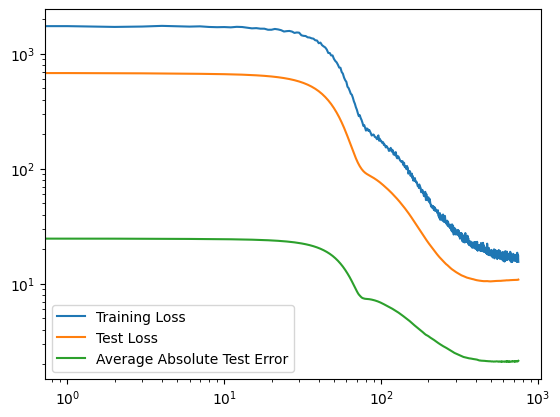

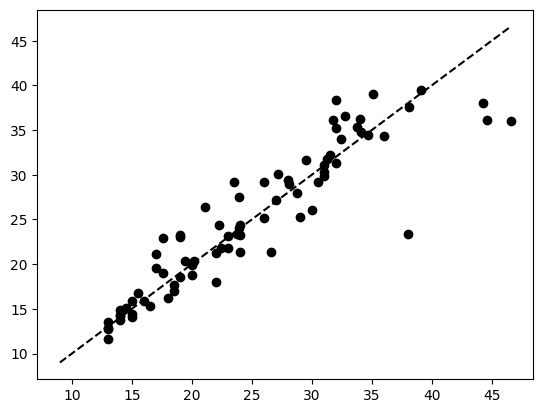

(10.864749650845043, 2.1374567106250275)

In [14]:
widths = [28, 10]
LR = 0.001
NUM_EPOCHS = 750
BATCH_SIZE = 128

x0 = widths + [LR] + [NUM_EPOCHS] + [BATCH_SIZE]

obj_wrapper(x0)